## Problem Solving Homework 6
This homework is intended for you to continue to develop your skills in both Pandas and linear modeling. You'll also use Seaborn to visualize the results. Again, you have to do some independent thinking to integrate various concepts you've learned in the class.

As usual, you must describe all code to get credit.

Part of this homework is taken from HW5 since we did not get to the parts of that homework. So, for those you'll be using the same NHANES data as in HW4 & HW5. This data contains the result of interviews and other data collection on thousands of US adults in the 70s and 80s.



### 1. NHANES Cleaning
Read in the NHANES NHEFS data into a data frame and clean it to make it more useful for analysis with the following steps. Make a cleaned version of the data frame, codeing each column into either a binary or a number value.  For columns coded into a binary value, you must code them so that 
More extreme values get put together. Like if possible values are "Love ice cream" "Like ice cream", "Don't care about ice cream", "Dislike ice cream", "Hate ice cream" then the more positive feelings about ice cream must be put together into the same category. As well, no category should have fewer than 250 people in it. (You can reuse your HW4 or HW5 code if you did one of these, but make sure you follow the requirements).

Remove WT81 as a feature (you can use the pandas [drop](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop.html) function

In [12]:
# Load packages and data
import pandas as pd
import numpy as np
nhefs = pd.read_csv('../data/nhefs.csv')

# For columns with categories, pull the category
cats = nhefs.loc[:,['alcoholfreq', 'exercise', 'quit']]
cats = cats.applymap(lambda x: int(x[0]))
# Replace the categorical columns in the main df with our encoded columns
nhefs = nhefs.drop(['alcoholfreq', 'exercise', 'quit'], axis=1)
nhefs = pd.concat([cats, nhefs], axis=1)

# nerve_med (nerve medication or not)
nhefs['nerve_med'] = (nhefs['nerve_med'] == 'Yes').astype(int)

# sex (male or not)
nhefs['sex'] = (nhefs['sex'] == 'man').astype(int)

# marital (married or not)
nhefs['marital'] = (nhefs['marital'] == 'married').astype(int)

# race (white or not)
nhefs['race'] = (nhefs['race'] == 'White').astype(int)

nhefs.dtypes

alcoholfreq         int64
exercise            int64
quit                int64
income            float64
price71           float64
price82           float64
smokeintensity      int64
smokeyrs            int64
tax71_82          float64
wt71              float64
wt82              float64
wt82_71           float64
school              int64
nerve_med           int32
sex                 int32
marital             int32
race                int32
dtype: object

## 2. Pair of predictors (question 3 from hw 5)
Get the best pair of two predictors of weight gain.  Your answer should print the best model summary as well as show how you decided this was the best pair. (We will discuss more than one predictor Nov 15 or 16)

In [13]:
# Use the log-likelihood to figure out which model is the *most* likely
# Drop NaNs
nhefs = nhefs.dropna()
import statsmodels.api as sm
# Drop the weight gain var so that we only look at predictors
wt82_71pred = nhefs.drop(['wt82_71'],axis=1)
# Set the current maximum at negative infinite likelihood (so that actual models will be higher)
current_max = -np.inf
# For each pair of predictors in the dataset
for col in wt82_71pred.columns:
    for other_col in wt82_71pred.drop([col],axis=1):
        # Create an X (predictors) df with pred1 and pred2
        X = nhefs.loc[:, [col, other_col]]
        # Add a constant
        X = sm.add_constant(X)
        # Make weight gain the y-value
        y = nhefs['wt82_71']
        # Fit a model of weight gain vs. these predictors
        model = sm.OLS(y, X).fit()
        # If the likelihood is closer to 0
        if model.llf > current_max:
            # Make it the current min
            current_max = model.llf
            # Make these the best preds
            best_preds = [col, other_col]

 # Create an X (predictors) df with the best predictors
X = nhefs.loc[:, best_preds]
# Add a constant
X = sm.add_constant(X)
# Make weight gain the y-value
y = nhefs['wt82_71']
two_model = sm.OLS(y, X).fit()
two_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                wt82_71   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 8.486e+20
Date:                Mon, 12 Dec 2022   Prob (F-statistic):               0.00
Time:                        17:14:23   Log-Likelihood:                 26424.
No. Observations:                1527   AIC:                        -5.284e+04
Df Residuals:                    1524   BIC:                        -5.283e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        6.36e-09   9.16e-10      6.940      0.000    4.56e-09    8.16e-09
wt71          -1.0000   2.57e-11  -3.89e+10      0.000      -1.000      -1.000
wt82           1.0000   2.46e-11   4.07e+10      0.000       1.000       1.000
==============================================================================
Omnibus:                      728.623   Durbin-Watson:                   1.951
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            36306.143
Skew:                          -1.465   Prob(JB):                         0.00
Kurtosis:                      26.707   Cond. No.                         506.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## 3. Model metrics (question 4 from hw 5) 
Calculate RMSE, R-squared, and likelihood of your best models without using the model functions (just using regular pandas/scipy.stats functions)

#### 3A: RMSE

In [17]:
# Get the model's predictions based on best_preds
X = nhefs.loc[:, best_preds] 
predictions = two_model.params['const'] + two_model.params[best_preds[0]] * nhefs[best_preds[0]] + two_model.params[best_preds[1]] * nhefs[best_preds[1]]

# Calculate RMSE
RMSE = ((predictions - nhefs['wt82_71'])**2 / len(predictions)).sum()

print(RMSE)

5.4592007826023084e-17


#### 3C: Likelihood

In [20]:
# Assuming a normal distribution for this numerical data
from scipy.stats import norm
probability = norm.pdf(nhefs['wt82_71'], loc=predictions, scale=nhefs['wt82_71'].std())
likelihood = np.log(probability).sum()

print(likelihood)

-4539.822086676868


## 4. Predict
### 4A: Make predictions
Predict weight gain using the best models you created in 2. Do not use the "predict" function of the model.  Your answer should create a Series for each of the two models. Print out the head of the Series and the describe of the series, for each series, with the models clearly labeled.


In [ ]:
# Get the model's predictions based on best_preds
X = nhefs.loc[:, best_preds] 
predictions = two_model.params['const'] + two_model.params[best_preds[0]] * nhefs[best_preds[0]] + two_model.params[best_preds[1]] * nhefs[best_preds[1]]

### 4B: Visualize predictions
Using seaborn, make a plot that has one predictor on the x-axis, and the wt82_71 on the y-axis, and the predicted values of wt82_71 also on the y-axis, in another color clearly indicated.  

Make this plots for each predictor, and also make a 3rd plot that combines the 2 predictors.

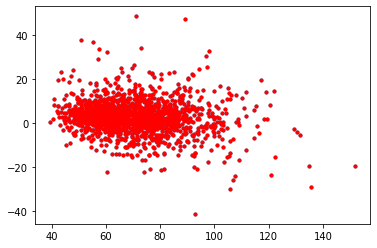

In [25]:
import matplotlib.pyplot as plt

f, ax = plt.subplots(1)
ax.plot(nhefs[best_preds[0]], nhefs['wt82_71'], '.')
ax.plot(nhefs[best_preds[0]], predictions, '.', color='red')
plt.show()